# 09i: Decision Quality Analysis

**Key Question:** What fraction of moves are real decisions? How punishing are mistakes?

**Analyses:**
1. **Q-gap Distribution**: Distribution of (best - second best) Q-values
2. **Mistake Impact**: V drop if you deviate from optimal
3. **Decision Sparsity**: Fraction of "real" decisions at various thresholds

In [1]:
# === CONFIGURATION ===
DATA_DIR = "/mnt/d/shards-standard/"
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

# === Setup imports ===
import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.notebook import tqdm
import random
import gc

from forge.analysis.utils import loading, features, viz, navigation
from forge.oracle import schema, tables

viz.setup_notebook_style()
print("Ready")

Ready


In [2]:
# Find available shard files
val_files = loading.find_shard_files(DATA_DIR + "val/")
test_files = loading.find_shard_files(DATA_DIR + "test/")
train_files = loading.find_shard_files(DATA_DIR + "train/")

all_files = val_files + test_files
random.shuffle(all_files)
random.shuffle(train_files)
shard_files = all_files + train_files

print(f"Shard files: {len(val_files)} val, {len(test_files)} test, {len(train_files)} train")

N_SHARDS = 30
MAX_ROWS = 20_000_000  # Lower to process more shards
print(f"Using up to {N_SHARDS} shards")

Shard files: 95 val, 95 test, 1124 train
Using up to 30 shards


## Data Collection: Q-values from Oracle Shards

In [3]:
def compute_q_gaps(df):
    """Compute Q-gap for each state in shard."""
    results = []
    
    # Extract Q columns
    q_cols = [c for c in df.columns if c.startswith('q')]
    if not q_cols:
        return []
    
    Q = df[q_cols].values  # Shape: (n_states, n_actions)
    depths = features.depth(df['state'].values)
    
    for i in range(len(df)):
        q_row = Q[i]
        # Valid Q-values (not -128)
        valid_mask = q_row > -128
        valid_q = q_row[valid_mask]
        n_valid = len(valid_q)
        
        if n_valid >= 2:
            sorted_q = np.sort(valid_q)[::-1]
            q_gap = sorted_q[0] - sorted_q[1]
            best_q = sorted_q[0]
            second_q = sorted_q[1]
        elif n_valid == 1:
            q_gap = 0  # Only one legal move = forced
            best_q = valid_q[0]
            second_q = np.nan
        else:
            continue  # Skip if no valid actions
        
        results.append({
            'depth': depths[i],
            'q_gap': q_gap,
            'n_actions': n_valid,
            'best_q': best_q,
            'second_q': second_q,
            'V': df['V'].iloc[i]
        })
    
    return results


# Collect Q-gap data
all_q_gaps = []
MIN_RECORDS = 10000

skipped = 0
processed = 0

for shard_file in tqdm(shard_files[:N_SHARDS], desc="Processing shards"):
    if len(all_q_gaps) >= MIN_RECORDS:
        break
    
    df, seed, decl_id = schema.load_file(shard_file)
    
    if len(df) > MAX_ROWS:
        skipped += 1
        del df
        gc.collect()
        continue
    
    processed += 1
    
    # Sample states (don't need all)
    sample_size = min(1000, len(df))
    sample_idx = np.random.choice(len(df), sample_size, replace=False)
    df_sample = df.iloc[sample_idx]
    
    gaps = compute_q_gaps(df_sample)
    all_q_gaps.extend(gaps)
    
    del df, df_sample
    gc.collect()

print(f"\nProcessed {processed} shards, skipped {skipped}")
print(f"Collected {len(all_q_gaps)} Q-gap records")

Processing shards:   0%|          | 0/30 [00:00<?, ?it/s]


Processed 11 shards, skipped 19
Collected 10979 Q-gap records


In [4]:
# Convert to dataframe
qgap_df = pd.DataFrame(all_q_gaps)
print(f"Q-gap records: {len(qgap_df)}")
print(f"\nDepth distribution:")
print(qgap_df['depth'].value_counts().sort_index())

Q-gap records: 10979

Depth distribution:
depth
1        9
2        8
3       12
4        8
5     1306
6      798
7      505
8      289
9     3489
10    1793
11     887
12     334
13     821
14     408
15     188
16      44
17      45
18      22
19       9
20       1
21       1
22       1
23       1
Name: count, dtype: int64


## Analysis 1: Q-gap Distribution

In [5]:
# Overall Q-gap statistics
print("Q-gap Statistics:")
print(f"  Mean: {qgap_df['q_gap'].mean():.2f}")
print(f"  Median: {qgap_df['q_gap'].median():.2f}")
print(f"  Std: {qgap_df['q_gap'].std():.2f}")
print(f"  Max: {qgap_df['q_gap'].max():.2f}")

# Forced moves (Q-gap = 0, meaning only 1 legal action)
forced_mask = qgap_df['n_actions'] == 1
pct_forced = forced_mask.mean() * 100
print(f"\nForced moves (1 legal action): {pct_forced:.1f}%")

# Near-forced (Q-gap < 1)
near_forced_mask = qgap_df['q_gap'] < 1
pct_near_forced = near_forced_mask.mean() * 100
print(f"Near-forced (Q-gap < 1): {pct_near_forced:.1f}%")

Q-gap Statistics:
  Mean: 2.93
  Median: 0.00
  Std: 7.53
  Max: 111.00

Forced moves (1 legal action): 38.9%
Near-forced (Q-gap < 1): 78.2%


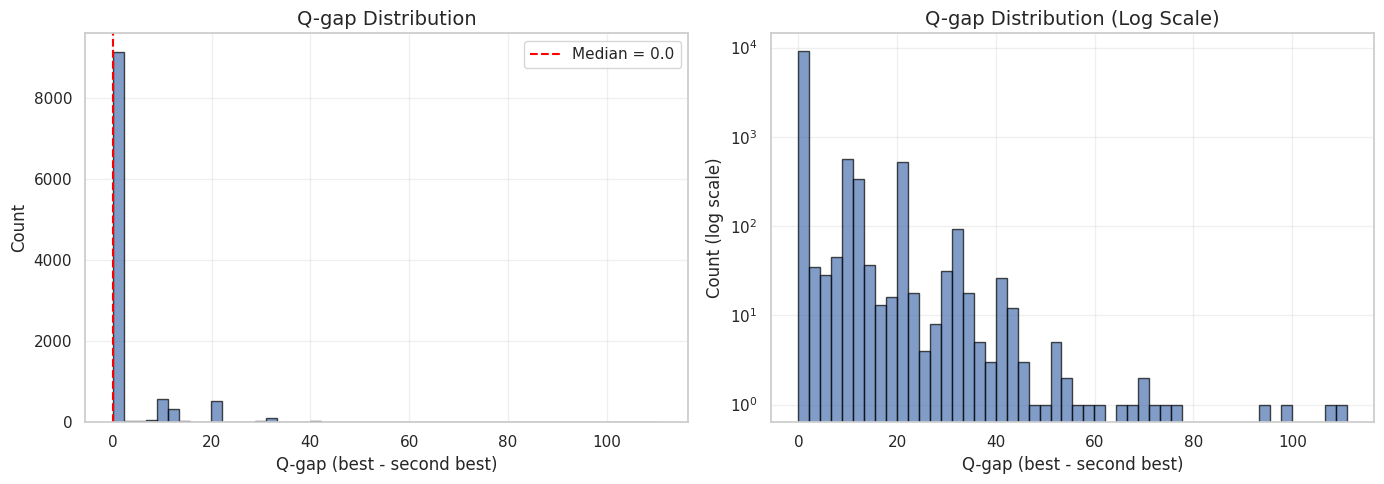

In [6]:
# Plot Q-gap distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of all Q-gaps
ax1.hist(qgap_df['q_gap'], bins=50, alpha=0.7, edgecolor='black')
ax1.axvline(x=qgap_df['q_gap'].median(), color='red', linestyle='--', 
            label=f'Median = {qgap_df["q_gap"].median():.1f}')
ax1.set_xlabel('Q-gap (best - second best)', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Q-gap Distribution', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Log scale for better visibility of tail
ax2.hist(qgap_df['q_gap'], bins=50, alpha=0.7, edgecolor='black')
ax2.set_yscale('log')
ax2.set_xlabel('Q-gap (best - second best)', fontsize=12)
ax2.set_ylabel('Count (log scale)', fontsize=12)
ax2.set_title('Q-gap Distribution (Log Scale)', fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../results/figures/09i_qgap_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## Analysis 2: Q-gap by Depth

In [7]:
# Q-gap statistics by depth
depth_stats = qgap_df.groupby('depth').agg({
    'q_gap': ['mean', 'median', 'std', 'count'],
    'n_actions': 'mean'
}).round(2)

print("Q-gap by Depth:")
print(depth_stats)

Q-gap by Depth:
      q_gap                     n_actions
       mean median    std count      mean
depth                                    
1      0.00    0.0   0.00     9      1.00
2      0.00    0.0   0.00     8      1.00
3      0.00    0.0   0.00    12      1.00
4      0.00    0.0   0.00     8      1.00
5      3.33    0.0   7.83  1306      1.66
6      2.68    0.0   7.02   798      1.64
7      1.94    0.0   5.82   505      1.60
8      4.20    0.0   8.18   289      2.00
9      3.19    0.0   8.41  3489      2.06
10     2.15    0.0   5.81  1793      2.02
11     2.60    0.0   6.87   887      2.00
12     5.37    0.0   9.70   334      3.00
13     3.35    0.0   8.14   821      2.33
14     2.19    0.0   5.88   408      2.21
15     2.62    0.0   6.58   188      2.09
16     3.82    0.0   6.97    44      4.00
17     0.73    0.0   2.45    45      2.40
18     2.64    0.0   4.42    22      2.68
19     5.78    0.0  11.85     9      2.00
20     8.00    8.0    NaN     1      5.00
21     0.00    0.0

/tmp/ipykernel_22896/2916592174.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  depth_forced = qgap_df.groupby('depth').apply(


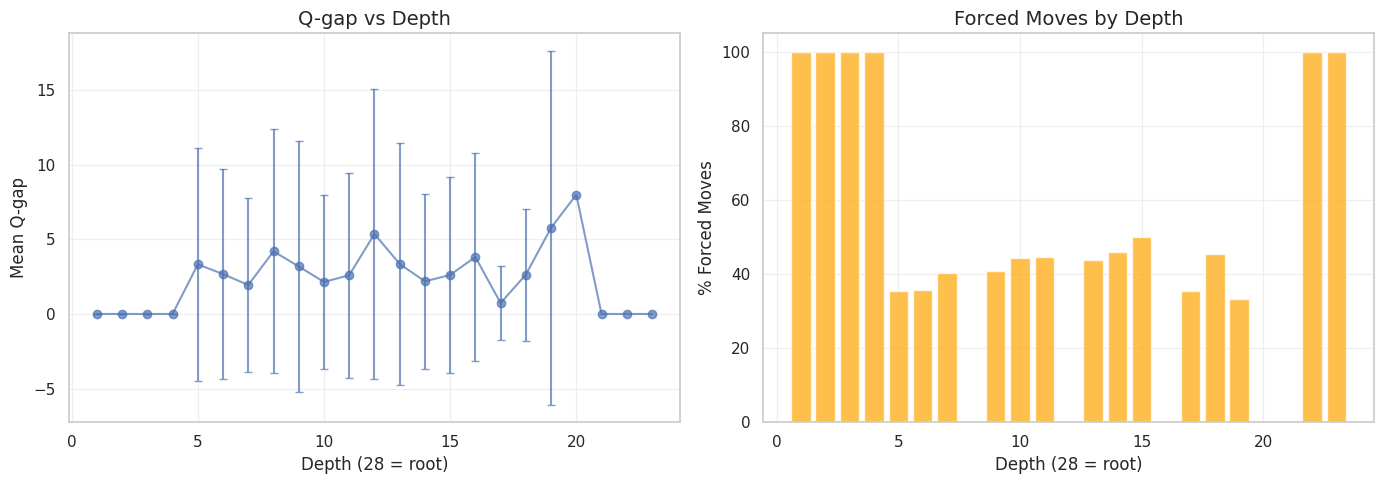

In [8]:
# Plot Q-gap by depth
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Mean Q-gap by depth
depth_means = qgap_df.groupby('depth')['q_gap'].agg(['mean', 'std'])
ax1.errorbar(depth_means.index, depth_means['mean'], 
             yerr=depth_means['std'], fmt='b-o', capsize=3, alpha=0.7)
ax1.set_xlabel('Depth (28 = root)', fontsize=12)
ax1.set_ylabel('Mean Q-gap', fontsize=12)
ax1.set_title('Q-gap vs Depth', fontsize=14)
ax1.grid(True, alpha=0.3)

# Percentage forced by depth
depth_forced = qgap_df.groupby('depth').apply(
    lambda g: (g['n_actions'] == 1).mean() * 100
)
ax2.bar(depth_forced.index, depth_forced.values, alpha=0.7, color='orange')
ax2.set_xlabel('Depth (28 = root)', fontsize=12)
ax2.set_ylabel('% Forced Moves', fontsize=12)
ax2.set_title('Forced Moves by Depth', fontsize=14)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../../results/figures/09i_qgap_by_depth.png', dpi=150, bbox_inches='tight')
plt.show()

## Analysis 3: Decision Sparsity at Various Thresholds

In [9]:
# Decision sparsity at various Q-gap thresholds
thresholds = [0, 1, 2, 5, 10, 20]
sparsity_results = []

for t in thresholds:
    n_decisions = (qgap_df['q_gap'] > t).sum()
    pct = n_decisions / len(qgap_df) * 100
    sparsity_results.append({
        'threshold': t,
        'n_decisions': n_decisions,
        'pct_decisions': pct
    })
    print(f"Q-gap > {t:2d}: {n_decisions:6d} ({pct:5.1f}%)")

sparsity_df = pd.DataFrame(sparsity_results)

Q-gap >  0:   2392 ( 21.8%)
Q-gap >  1:   2384 ( 21.7%)
Q-gap >  2:   1839 ( 16.8%)
Q-gap >  5:   1790 ( 16.3%)
Q-gap > 10:   1170 ( 10.7%)
Q-gap > 20:    485 (  4.4%)


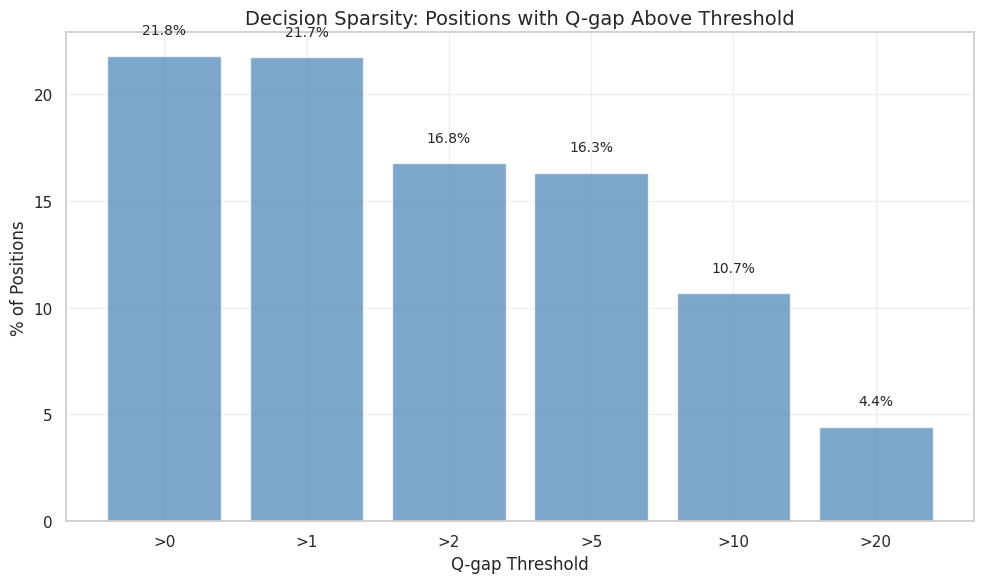

In [10]:
# Plot decision sparsity
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(range(len(sparsity_df)), sparsity_df['pct_decisions'], 
       tick_label=[f'>{t}' for t in sparsity_df['threshold']], 
       alpha=0.7, color='steelblue')
ax.set_xlabel('Q-gap Threshold', fontsize=12)
ax.set_ylabel('% of Positions', fontsize=12)
ax.set_title('Decision Sparsity: Positions with Q-gap Above Threshold', fontsize=14)
ax.grid(True, alpha=0.3, axis='y')

# Add percentages on bars
for i, (idx, row) in enumerate(sparsity_df.iterrows()):
    ax.text(i, row['pct_decisions'] + 1, f"{row['pct_decisions']:.1f}%", 
            ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('../../results/figures/09i_decision_sparsity.png', dpi=150, bbox_inches='tight')
plt.show()

## Analysis 4: Mistake Impact

In [11]:
# The Q-gap IS the mistake impact (V drop for taking 2nd best)
# Multi-action states only
multi_action = qgap_df[qgap_df['n_actions'] > 1]

print("Mistake Impact (Q-gap for multi-action states):")
print(f"  Mean V drop for 2nd-best: {multi_action['q_gap'].mean():.2f}")
print(f"  Median V drop: {multi_action['q_gap'].median():.2f}")
print(f"  Std: {multi_action['q_gap'].std():.2f}")
print(f"\nNumber of multi-action states: {len(multi_action)} ({len(multi_action)/len(qgap_df)*100:.1f}%)")

Mistake Impact (Q-gap for multi-action states):
  Mean V drop for 2nd-best: 4.80
  Median V drop: 0.00
  Std: 9.15

Number of multi-action states: 6706 (61.1%)


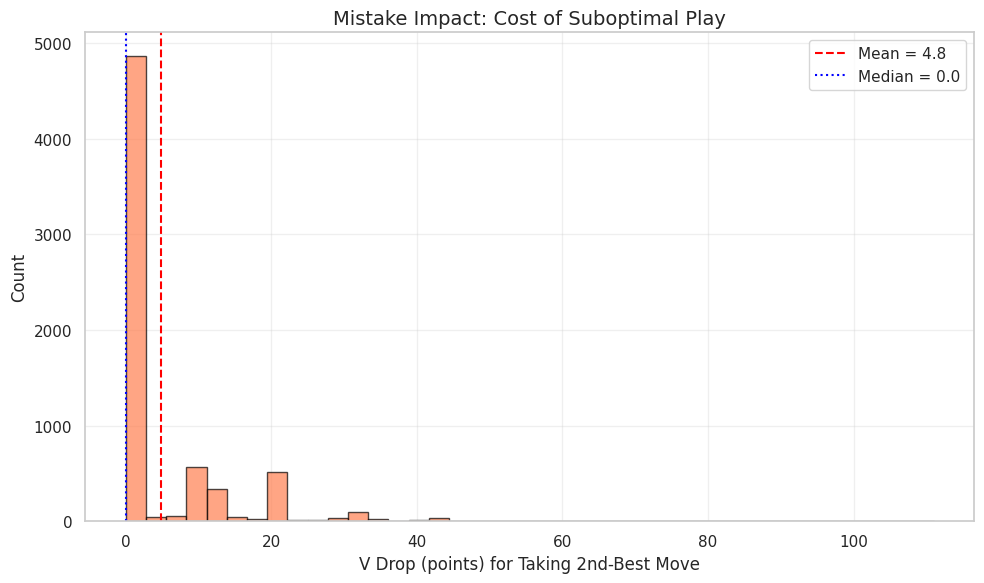

In [12]:
# Mistake impact distribution
if len(multi_action) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.hist(multi_action['q_gap'], bins=40, alpha=0.7, edgecolor='black', color='coral')
    ax.axvline(x=multi_action['q_gap'].mean(), color='red', linestyle='--', 
               label=f'Mean = {multi_action["q_gap"].mean():.1f}')
    ax.axvline(x=multi_action['q_gap'].median(), color='blue', linestyle=':', 
               label=f'Median = {multi_action["q_gap"].median():.1f}')
    
    ax.set_xlabel('V Drop (points) for Taking 2nd-Best Move', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title('Mistake Impact: Cost of Suboptimal Play', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../../results/figures/09i_mistake_impact.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Not enough multi-action states for histogram")

## Summary Statistics

In [13]:
# Create summary table
summary = {
    'metric': [
        'Total states analyzed',
        'Mean Q-gap',
        'Median Q-gap',
        '% Forced (1 legal action)',
        '% Multi-action',
        'Mean n_actions (when multi)',
        '% with Q-gap > 5',
        'Mean mistake cost (2nd-best)',
    ],
    'value': [
        len(qgap_df),
        f"{qgap_df['q_gap'].mean():.2f}",
        f"{qgap_df['q_gap'].median():.2f}",
        f"{(qgap_df['n_actions'] == 1).mean() * 100:.1f}%",
        f"{(qgap_df['n_actions'] > 1).mean() * 100:.1f}%",
        f"{multi_action['n_actions'].mean():.2f}" if len(multi_action) > 0 else "N/A",
        f"{(qgap_df['q_gap'] > 5).mean() * 100:.1f}%",
        f"{multi_action['q_gap'].mean():.2f}" if len(multi_action) > 0 else "N/A",
    ]
}

summary_df = pd.DataFrame(summary)
print(summary_df.to_string(index=False))

summary_df.to_csv('../../results/tables/09i_decision.csv', index=False)
print("\nSaved to results/tables/09i_decision.csv")

                      metric value
       Total states analyzed 10979
                  Mean Q-gap  2.93
                Median Q-gap  0.00
   % Forced (1 legal action) 38.9%
              % Multi-action 61.1%
 Mean n_actions (when multi)  2.65
            % with Q-gap > 5 16.3%
Mean mistake cost (2nd-best)  4.80

Saved to results/tables/09i_decision.csv


## Conclusion

In [14]:
print("=" * 60)
print("DECISION QUALITY ANALYSIS CONCLUSIONS")
print("=" * 60)

# Decision sparsity
pct_forced = (qgap_df['n_actions'] == 1).mean() * 100
pct_multi = 100 - pct_forced
print(f"\n1. DECISION SPARSITY")
print(f"   Forced moves (1 legal action): {pct_forced:.1f}%")
print(f"   Multi-action positions: {pct_multi:.1f}%")
if pct_forced > 70:
    print(f"   VERY SPARSE: Most positions have no real choice.")
elif pct_forced > 50:
    print(f"   SPARSE: Majority of positions are forced.")
else:
    print(f"   MODERATE: Many positions have genuine choices.")

# Mistake impact
print(f"\n2. MISTAKE IMPACT (when choice exists)")
if len(multi_action) > 0:
    mean_cost = multi_action['q_gap'].mean()
    print(f"   Mean cost of 2nd-best move: {mean_cost:.1f} points")
    if mean_cost > 10:
        print(f"   PUNISHING: Mistakes are very costly.")
    elif mean_cost > 3:
        print(f"   MODERATE: Mistakes have significant cost.")
    else:
        print(f"   FORGIVING: Suboptimal play is often okay.")
else:
    print(f"   Not enough data to assess.")

# Key decisions
print(f"\n3. KEY DECISION POINTS")
pct_big = (qgap_df['q_gap'] > 10).mean() * 100
print(f"   High-stakes decisions (Q-gap > 10): {pct_big:.1f}%")
mean_per_game = pct_big / 100 * 28  # Approx decisions per 28-move game
print(f"   Estimated per game: ~{mean_per_game:.1f} critical decisions")

print("\n" + "=" * 60)

DECISION QUALITY ANALYSIS CONCLUSIONS

1. DECISION SPARSITY
   Forced moves (1 legal action): 38.9%
   Multi-action positions: 61.1%
   MODERATE: Many positions have genuine choices.

2. MISTAKE IMPACT (when choice exists)
   Mean cost of 2nd-best move: 4.8 points
   MODERATE: Mistakes have significant cost.

3. KEY DECISION POINTS
   High-stakes decisions (Q-gap > 10): 10.7%
   Estimated per game: ~3.0 critical decisions

